In [1]:
include("blosum.jl")
using ProRF, PyPlot, AverageShiftedHistograms, Statistics, LinearRegression, DataFrames, GLM

In [2]:
R = RF("Data/TDP43")
@load "Save/f1.jld2" F Y PY
X, Y, L = get_data_b(R, 'B', norm=true);

In [23]:
function ProRF._view_result(predict_test::Vector{Float64}, y_test::Vector{Float64}, nbin::Int)
    nrmse_val = nrmse(predict_test, y_test)
    if length(y_test) ≤ 150
        scatter(y_test, predict_test, color="#440154", s=20)
    else
        color = Vector{Float64}()
        ke = AverageShiftedHistograms.Kernels.gaussian
        kde = ash(y_test, predict_test, nbin=nbin, kernelx=ke, kernely=ke)
        for (tru, val) in zip(y_test, predict_test)
            push!(color, AverageShiftedHistograms.pdf(kde, tru, val))
        end
        sorted_idx = sortperm(color)
        scatter(y_test[sorted_idx], predict_test[sorted_idx], c=color[sorted_idx], s=3)
        colorbar()
    end

    data = DataFrame(X=y_test, Y=predict_test)
    bl = 0.1
    f1, f2 = x -> x + bl, x -> x - bl

    PyPlot.title("Random Forest Regression Result")
    xlabel("True Values")
    ylabel("Predictions")
    axis("equal")
    axis("square")
    xlim(-max(0, -xlim()[1]), xlim()[2])
    ylim(-max(0, -ylim()[1]), ylim()[2])
    annotate((@sprintf "NRMSE : %.4f" nrmse_val), (([0.97  0.03] * collect(xlim()))[1] , ([0.05 0.95] * collect(ylim()))[1]))
    plot([-1000, 1000], [-1000, 1000], color="black")
    plot([-1000, 1000], f1.([-1000, 1000]), color="red", linestyle = "--")
    plot([-1000, 1000], f2.([-1000, 1000]), color="red", linestyle = "--")
    savefig("Fig/f1-1.tiff", dpi=600, bbox_inches="tight")
    ProRF.@show_pyplot
    @printf "NRMSE : %.6f\n" nrmse_val
    return nrmse_val
end

function ProRF._view_importance(F::Vector{Float64}, L::Vector{String}; show_number::Int=20, index::Union{Nothing, Vector{String}}=nothing)
    data_len = length(F)
    F ./= maximum(F)
    show_number = min(data_len, show_number)
    sorted_idx = sortperm(F, rev=true)
    bar_pos = collect(data_len:-1:1) .- 0.5
    barh(bar_pos[1:show_number], F[sorted_idx][1:show_number], align="center")
    yticks(bar_pos[1:show_number], L[sorted_idx][1:show_number])
    xlabel("Feature Importance")
    ylabel("Amino acid Location")
    PyPlot.title("Relative Mean Absolute Shapley Value")
    savefig("Fig/f1-2.tiff", dpi=600, bbox_inches="tight")
    ProRF.@show_pyplot
end

function return_edit_ind(Y::AbstractVector, data_state::UInt64; test_size::Float64=0.3, test_mode::Bool=true)
    n = length(Y)
    idx = shuffle(MersenneTwister(data_state), 1:n)
    ed_idx = test_mode ? view(idx, 1:floor(Int, test_size*n)) : view(idx, (floor(Int, test_size*n)+1):n)
    return ed_idx
end

return_edit_ind (generic function with 1 method)

In [18]:
clipboard(join(py, ' '))

In [25]:
length(findall(x -> x ≤ 0.1, abs.(y .- py))) / length(y)

0.7639027431421447

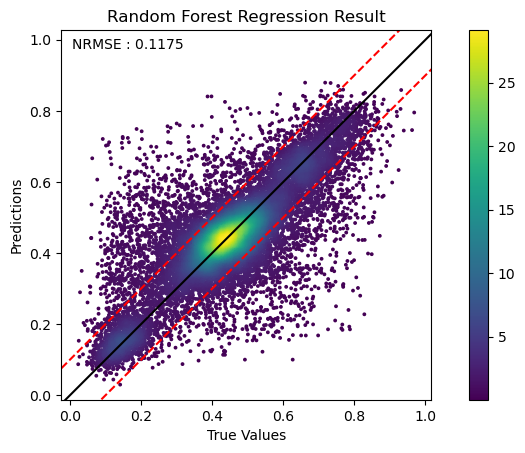

NRMSE : 0.117531


In [24]:
view_result(PY, Y, data_state);

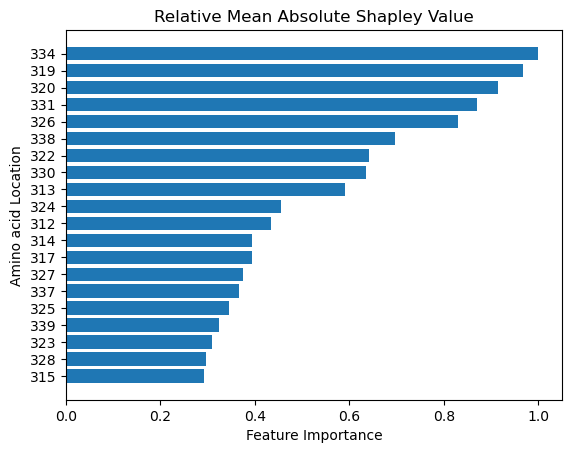

In [21]:
view_importance(R, get_amino_loc(R, L), F, show_number=20);